In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [10]:

def BS_vega(CP,S0, K, sigma, t, T, r):
    
    tau = T - t
    
    if tau <= 0:
        return 0.0
    
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    
    vega = S0 * norm.pdf(d1) * np.sqrt(tau)
    
    return vega

def GeneratePathsGBM(NoOfPaths, NoOfSteps, T, r, sigma, S_0):  
    
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])  # números aleatorios estándar
    X = np.zeros([NoOfPaths, NoOfSteps + 1])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])
    time = np.zeros([NoOfSteps + 1])
        
    X[:, 0] = np.log(S_0)  # log del precio inicial
    
    dt = T / float(NoOfSteps)  # tamaño del paso temporal
    
    for i in range(0, NoOfSteps):
        # Normalizar Z para que tenga media 0 y varianza 1 en cada paso
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        
        W[:, i+1] = W[:, i] + np.sqrt(dt) * Z[:, i]  # camino de Wiener
        X[:, i+1] = X[:, i] + (r - 0.5 * sigma**2) * dt + sigma * (W[:, i+1] - W[:, i])
        time[i+1] = time[i] + dt
        
    S = np.exp(X)  # precios del activo en cada tiempo y simulación
    paths = {"time": time, "S": S}
    
    return paths

In [6]:
def PathwiseVega(CP, S0, S, K, r, T,sigma):
    ST = S[:, -1]
    
    if CP=='call':
        indicator = (ST > K).astype(float)

    elif CP=='put':
        indicator = (ST < K).astype(float)
    
    #derivada de ST respecto a Sigma
    term = (1.0 / sigma) * ST * (
            np.log(ST / S0) - (r + 0.5 * sigma**2) * T)
    vega = np.exp(-r * T) * np.mean(indicator * term)
 

    return vega


In [7]:
CP    = 'call'
S0    = 1.0
r     = 0.06
sigma = 0.3
T     = 1.0
K     = S0
t     = 0.0

In [12]:
NoOfSteps = 1000

# Vega exacta de Black-Scholes
vega_Exact = BS_vega(CP,S0, K, sigma, t, T, r)

# Diferentes números de caminos para ver su convergencia
NoOfPathsV = np.round(np.linspace(5, 20000, 50))
vegaPathWiseV = np.zeros(len(NoOfPathsV))


Running simulation with 5 paths
Running simulation with 413 paths
Running simulation with 821 paths
Running simulation with 1229 paths
Running simulation with 1637 paths
Running simulation with 2045 paths
Running simulation with 2453 paths
Running simulation with 2861 paths
Running simulation with 3269 paths
Running simulation with 3678 paths
Running simulation with 4086 paths
Running simulation with 4494 paths
Running simulation with 4902 paths
Running simulation with 5310 paths
Running simulation with 5718 paths
Running simulation with 6126 paths
Running simulation with 6534 paths
Running simulation with 6942 paths
Running simulation with 7350 paths
Running simulation with 7758 paths
Running simulation with 8166 paths
Running simulation with 8574 paths
Running simulation with 8982 paths
Running simulation with 9390 paths
Running simulation with 9798 paths
Running simulation with 10207 paths
Running simulation with 10615 paths
Running simulation with 11023 paths
Running simulation wit

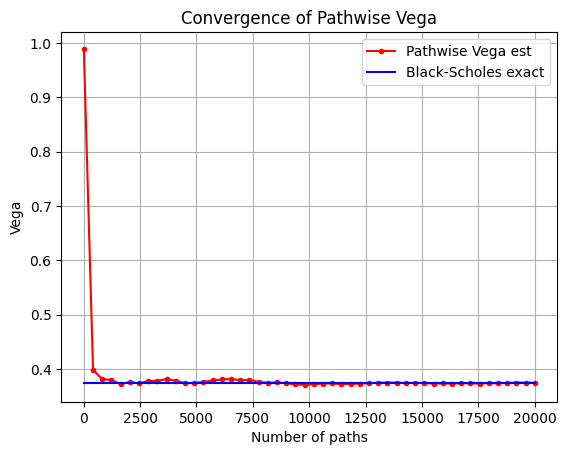

In [13]:
for idx, nPaths in enumerate(NoOfPathsV):
    print(f'Running simulation with {int(nPaths)} paths')
    np.random.seed(3)  
    
    # Generar caminos de GBM
    paths = GeneratePathsGBM(int(nPaths), NoOfSteps, T, r, sigma, S0)
    S = paths["S"]
    
    #Pathwise Vega
    vega_pathwise = PathwiseVega(CP, S0, S, K, r, T, sigma)
    vegaPathWiseV[idx] = vega_pathwise

# Graficas
plt.figure()
plt.grid()
plt.plot(NoOfPathsV, vegaPathWiseV, '.-r', label='Pathwise Vega est')
plt.plot(NoOfPathsV, vega_Exact*np.ones(len(NoOfPathsV)), 'b', label='Black-Scholes exact')
plt.xlabel('Number of paths')
plt.ylabel('Vega')
plt.title('Convergence of Pathwise Vega')
plt.legend()
plt.show()

Algunas cosas que podemos decir son:
1. Pathwise (línea roja) converge rápidamente al valor de Black-Scholes exacto (línea azul) a medida que aumenta el número de caminos.
2. A partir de aproximadamente 5.000–10.000 caminos, la estimación se estabiliza cerca del valor teórico (approx 0.375).

Pathwise es consistente: su esperanza converge al valor exacto de Vega para un número suficientemente grande de simulaciones.

Varianza inicial alta con pocos caminos. Para un número muy pequeño de caminos (<500), el estimador es muy ruidoso y está alejado del valor exacto (hasta 1 al inicio).

Esto es normal en Monte Carlo: con pocos caminos, la varianza del estimador es grande. Con más caminos, la varianza disminuye y la curva se suaviza.

